In [ ]:
# @title Import Requirements
from IPython.display import clear_output
import os
import io
import gc
import random

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tsnecuda import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tqdm.notebook import tqdm

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from transformers import (
    BertConfig,
    BertTokenizer,
    TFBertForSequenceClassification
)

SELECTED_GPU = 0
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_visible_devices(gpus[SELECTED_GPU], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[SELECTED_GPU], True)
    print(gpus[SELECTED_GPU])
  except RuntimeError as e:
    print(e)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
fdir = '/home/username/NLP/Data/SentEval/data/probing/'
BATCH_SIZE = 256
MAX_LENGTH = 48

TASK_NAME = 'bigram_shift.txt'

CLASSIFIER_MODEL_FPATH = '/home/username/NLP/Models/SentEvalAnalysis/BERT_AVG_Classifiers/'

pretrained_loc = "bert-base-uncased"
print("Running with:", pretrained_loc)

Running with: bert-base-uncased


In [ ]:
# @title Required Functions & Classes
def load_probing_data(fpath, additive=''):
    task_data = {'train': {'X': [], 'y': []},
                 'dev': {'X': [], 'y': []},
                 'test': {'X': [], 'y': []}}


    tok2split = {'tr': 'train', 'va': 'dev', 'te': 'test'}
    with io.open(fpath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.rstrip().split('\t')
            task_data[tok2split[line[0]]]['X'].append(additive + line[-1])
            task_data[tok2split[line[0]]]['y'].append(line[1])

        if fpath == '~/NLP/Data/SentEval/data/probing/tree_depth.txt':
            labels = ['5', '6', '7', '8', '9', '10', '11']
            tok2label = dict(zip(labels, [0, 1. / 6, 2. / 6, 3. / 6, 4. / 6, 5. / 6, 1]))
        else:
            labels = sorted(np.unique(task_data['train']['y']))
            tok2label = dict(zip(labels, range(len(labels))))
        nclasses = len(tok2label)

        for split in task_data:
            for i, y in enumerate(task_data[split]['y']):
                task_data[split]['y'][i] = tok2label[y]

    return task_data, tok2label, nclasses

class BertReprProbing(tf.keras.Model):
    def __init__(self, bert_model, **kwargs):
        super(BertReprProbing, self).__init__(name="BertReprProbing")
        self.bert = bert_model

    def call(self, inputs, **kwargs):
        middle_hidden_states = self.bert(inputs, **kwargs)[2]
        output = []
        for i in range(1, 13):
            output.append(middle_hidden_states[i])
        return tf.stack(output)

@tf.function
def tf_average(hidden_states, att_mask, w):
  max_length = tf.cast(tf.shape(att_mask)[1], tf.float32)
  att_mask = tf.cast(att_mask[:, 1:], tf.float32)
  avg = tf.reshape(tf.matmul(tf.transpose(hidden_states[:, 1:] * tf.expand_dims(att_mask, axis=-1), perm=[0, 2, 1]), w), (-1, 768))
  avg = avg * tf.cast((max_length - 1.0) / tf.reduce_sum(att_mask, axis=-1, keepdims=True), tf.float32)
  return avg

In [ ]:
# @title Load BERT Model
config = BertConfig.from_pretrained(pretrained_loc, output_hidden_states=True)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
loaded_model = TFBertForSequenceClassification.from_pretrained(pretrained_loc,
                                                               config=config)

probing_model = BertReprProbing(loaded_model.bert)
clear_output()
print("Done!")

Done!


In [ ]:
def index_to_id(example, target_pos):
  pos = 1 # 1 for counting CLS
  for index in range(target_pos):
    pos += len(tokenizer.encode(example[index], add_special_tokens=False))
  return list(range(pos, pos+len(tokenizer.encode(example[target_pos], add_special_tokens=False))))

In [ ]:
PUNC = [".", ",", "!", "@", "#", "$", "%", "&", "*", "(", ")", "'", "\"", ";", ":", "?", "<", ">", "{", "}", "[", "]", "\\", "/", "?"]

In [ ]:
# @title Probe Feature Extraction
probe_path = fdir + TASK_NAME
task_data, tok2label, nclasses = load_probing_data(probe_path)
print("Probe Loaded:", TASK_NAME)

del task_data['train']
del task_data['dev']
gc.collect()

# Keep Only Original Examples

inverted_data = []
original_data = []
first_position = []
second_position = []

for data in zip(task_data['test']['X'], task_data['test']['y']):
  example, label = data
  if label == 0:
    continue

  original_data.append(example)  
  chunked = example.split()

  while(True):
    bi_pos = np.random.randint(low=1, high=len(chunked)-1)
    if chunked[bi_pos] not in PUNC and chunked[bi_pos+1] not in PUNC:
      break
    
  
  first_position.append(index_to_id(chunked, bi_pos))
  second_position.append(index_to_id(chunked, bi_pos+1))

  chunked[bi_pos], chunked[bi_pos+1] = chunked[bi_pos+1], chunked[bi_pos]
  chunked = ' '.join(chunked)

  inverted_data.append(chunked)



no_examples = len(original_data)
steps = int(np.ceil(no_examples / BATCH_SIZE))


hidden_representations = np.zeros((12, no_examples, MAX_LENGTH, 768), dtype=np.float32)
inverted_hidden_representations = np.zeros((12, no_examples, MAX_LENGTH, 768), dtype=np.float32)
token_ids = np.zeros((no_examples, MAX_LENGTH), dtype=np.int32)
inverted_token_ids = np.zeros((no_examples, MAX_LENGTH), dtype=np.int32)
att_masks = np.zeros((no_examples, MAX_LENGTH), dtype=np.int32)

print("Starting probe feature extraction:", TASK_NAME)

for i in tqdm(range(steps)):
    tokens_batched = tokenizer.batch_encode_plus(original_data[i * BATCH_SIZE:min((i + 1) * BATCH_SIZE, no_examples)],
                                                 max_length=MAX_LENGTH,
                                                 return_tensors='tf',
                                                 truncation=True,
                                                 padding='max_length')
    hidden_representations[:,
    i * BATCH_SIZE:(i + 1) * BATCH_SIZE, :, :] = probing_model(tokens_batched, training=False).numpy()
    token_ids[i * BATCH_SIZE:(i + 1) * BATCH_SIZE, :] = tokens_batched['input_ids']
    att_masks[i * BATCH_SIZE:(i + 1) * BATCH_SIZE, :] = tokens_batched['attention_mask']



    tokens_batched = tokenizer.batch_encode_plus(inverted_data[i * BATCH_SIZE:min((i + 1) * BATCH_SIZE, no_examples)],
                                                 max_length=MAX_LENGTH,
                                                 return_tensors='tf',
                                                 truncation=True,
                                                 padding='max_length')
    inverted_hidden_representations[:,
    i * BATCH_SIZE:(i + 1) * BATCH_SIZE, :, :] = probing_model(tokens_batched, training=False).numpy()
    inverted_token_ids[i * BATCH_SIZE:(i + 1) * BATCH_SIZE, :] = tokens_batched['input_ids']
                                                                                                                          
    

Probe Loaded: bigram_shift.txt
Starting probe feature extraction: bigram_shift.txt


In [ ]:
# @title Importance Computation (Original)
saliances_orig = np.zeros((12, no_examples, nclasses, MAX_LENGTH))
weights = tf.Variable(np.ones((MAX_LENGTH-1, 1)) / (MAX_LENGTH-1), dtype=tf.float32, trainable=True)
BATCH_SIZE = 128
steps = int(np.ceil(no_examples / BATCH_SIZE))
for i in range(12):
    print("Load classifier", i)
    classifier = tf.keras.models.load_model(CLASSIFIER_MODEL_FPATH + TASK_NAME[:-4] + '/' + str(i))
    for j in tqdm(range(steps)):
        with tf.GradientTape() as tape:
            avgs = tf_average(hidden_representations[i, j * BATCH_SIZE:(j + 1) * BATCH_SIZE, :, :],
                              att_masks[j * BATCH_SIZE:(j + 1) * BATCH_SIZE, :], weights)
            probs = classifier(avgs)[:, 0]
        grads = tape.gradient(probs, avgs)
        salience_scores = tf.expand_dims(grads, axis=1) * hidden_representations[i, j * BATCH_SIZE:(j + 1) * BATCH_SIZE, :, :] * tf.cast(tf.expand_dims(att_masks[j * BATCH_SIZE:(j + 1) * BATCH_SIZE, :], axis=-1), dtype=tf.float32)
        saliances_orig[i][j * BATCH_SIZE:(j + 1) * BATCH_SIZE, 0, 1:] = tf.reduce_sum(salience_scores, axis=-1).numpy()[:,1:]
        saliances_orig[i][j * BATCH_SIZE:(j + 1) * BATCH_SIZE, 1, 1:] = -saliances_orig[i][j * BATCH_SIZE:(j + 1) * BATCH_SIZE, 0, 1:]
        

In [ ]:
# @title Importance Computation (Inverted)
saliances_inverted = np.zeros((12, no_examples, nclasses, MAX_LENGTH))
weights = tf.Variable(np.ones((MAX_LENGTH-1, 1)) / (MAX_LENGTH-1), dtype=tf.float32, trainable=True)
BATCH_SIZE = 128
steps = int(np.ceil(no_examples / BATCH_SIZE))
for i in range(12):
    print("Load classifier", i)
    classifier = tf.keras.models.load_model(CLASSIFIER_MODEL_FPATH + TASK_NAME[:-4] + '/' + str(i))
    for j in tqdm(range(steps)):
        with tf.GradientTape() as tape:
            avgs = tf_average(inverted_hidden_representations[i, j * BATCH_SIZE:(j + 1) * BATCH_SIZE, :, :],
                              att_masks[j * BATCH_SIZE:(j + 1) * BATCH_SIZE, :], weights)
            probs = classifier(avgs)[:, 0]
        grads = tape.gradient(probs, avgs)
        salience_scores = tf.expand_dims(grads, axis=1) * inverted_hidden_representations[i, j * BATCH_SIZE:(j + 1) * BATCH_SIZE, :, :] * tf.cast(tf.expand_dims(att_masks[j * BATCH_SIZE:(j + 1) * BATCH_SIZE, :], axis=-1), dtype=tf.float32)
        saliances_inverted[i][j * BATCH_SIZE:(j + 1) * BATCH_SIZE, 0, 1:] = tf.reduce_sum(salience_scores, axis=-1).numpy()[:,1:]
        saliances_inverted[i][j * BATCH_SIZE:(j + 1) * BATCH_SIZE, 1, 1:] = -saliances_inverted[i][j * BATCH_SIZE:(j + 1) * BATCH_SIZE, 0, 1:]
      

In [ ]:
sns.reset_orig()
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

### Spearman Correlation

In [ ]:
from scipy.stats import spearmanr

gold_grad = np.zeros((no_examples, MAX_LENGTH), dtype=np.float64)
for i in range(no_examples):
  mask = np.zeros(MAX_LENGTH)
  mask[first_position[i]] = 1
  mask[second_position[i]] = 1
  gold_grad[i] = mask

inverted_layer_spearman = []
original_layer_spearman = []
for layer in range(12):
  inv_spearmans = []
  orig_spearmans = []
  for ex in range(no_examples):
    inv_spearmans.append(spearmanr(saliances_inverted[layer, ex, 0][0:np.sum(att_masks[ex])], gold_grad[ex][0:np.sum(att_masks[ex])])[0])
    orig_spearmans.append(spearmanr(saliances_orig[layer, ex, 1][0:np.sum(att_masks[ex])], gold_grad[ex][0:np.sum(att_masks[ex])])[0])
  inverted_layer_spearman.append(np.mean(inv_spearmans))
  original_layer_spearman.append(np.mean(orig_spearmans))

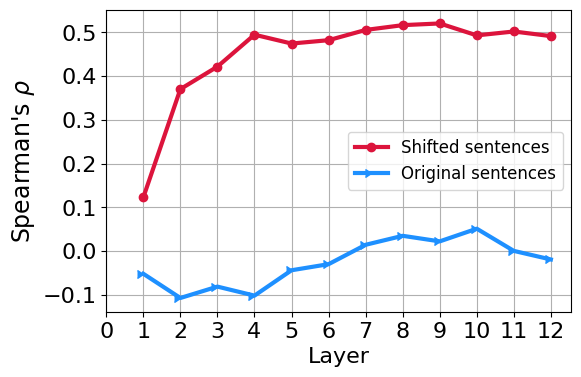

In [ ]:
# sns.reset_orig()
plt.plot(range(1, 13), inverted_layer_spearman, 'crimson', label="Shifted sentences", marker='o', linewidth=3)
plt.plot(range(1, 13), original_layer_spearman, 'dodgerblue', label="Original sentences", marker=5, linewidth=3)
plt.legend(loc='best', prop={'size': 12})
plt.xlabel("Layer", fontsize=16)
plt.ylabel(r"Spearman's $\rho$", fontsize=17)
plt.xticks(range(13), fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams['xtick.labelsize']=13
plt.rcParams['ytick.labelsize']=13
plt.grid()
plt.show()

### Gradient HeatMap

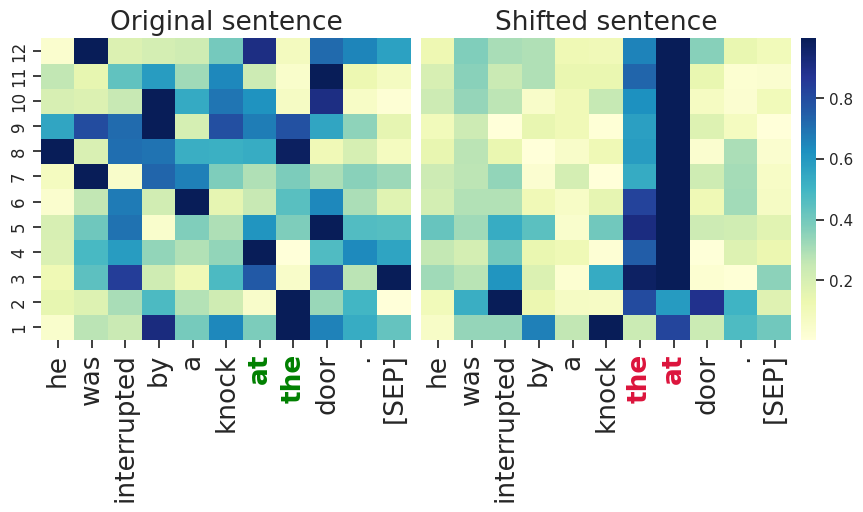

In [ ]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()

fig, axs = plt.subplots(ncols=3, gridspec_kw=dict(width_ratios=[5,5,0.2]))
fig.subplots_adjust(wspace=0.04)
fig.set_dpi(100)
fig.set_figwidth(10)
fig.set_figheight(4)

examples = [1]#600
for ind, ex in enumerate(examples):

  original_tokens = []
  for i in range(1, sum(att_masks[ex])):
    original_tokens.append(tokenizer.convert_ids_to_tokens(token_ids[ex][i].item()))

  original_grad = np.abs(saliances_orig[:, ex, 1, 1:np.sum(att_masks[ex])])
  original_grad /= np.max(original_grad, axis=1, keepdims=True)

  inverted_tokens = []
  for i in range(1, sum(att_masks[ex])):
    inverted_tokens.append(tokenizer.convert_ids_to_tokens(inverted_token_ids[ex][i].item()))

  inverted_grad = np.abs(saliances_inverted[:, ex, 0, 1:np.sum(att_masks[ex])])
  inverted_grad /= np.max(inverted_grad, axis=1, keepdims=True)
  

  sns.heatmap(original_grad, xticklabels=original_tokens, cmap="YlGnBu", cbar=False, ax = axs[0])

  axs[0].set_yticklabels(range(1, 13), va="center", fontsize=12)
  axs[0].set_xticklabels(original_tokens, rotation=90, size=19)
  axs[0].tick_params(left=True, bottom=True)
  axs[0].get_xticklabels()[6].set_color("green")
  axs[0].get_xticklabels()[7].set_color("green")
  axs[0].get_xticklabels()[6].set_fontweight("bold")
  axs[0].get_xticklabels()[7].set_fontweight("bold")
  
  axs[0].invert_yaxis()  
  axs[0].set_title("Original sentence", fontsize=19)


  sns.heatmap(inverted_grad, xticklabels=inverted_tokens, cmap="YlGnBu", cbar=True, cbar_ax=axs[2], ax = axs[1])
  axs[1].set_xticklabels(inverted_tokens, rotation=90, size=19)

  cbar = axs[1].collections[0].colorbar
  cbar.set_ticks([0.2, 0.4, 0.6, 0.8])

  axs[1].tick_params(bottom=True)
  axs[1].get_xticklabels()[6].set_color("crimson")
  axs[1].get_xticklabels()[7].set_color("crimson")
  axs[1].get_xticklabels()[6].set_fontweight("bold")
  axs[1].get_xticklabels()[7].set_fontweight("bold")

  axs[1].set_yticks([])
  axs[1].invert_yaxis()  
  axs[1].set_title("Shifted sentence", fontsize=19)

  # fig.tight_layout()
# plt.savefig('rat_bert_att_{}.png'.format(ex_id), format='png', transparent=True, dpi=360, bbox_inches='tight')

In [ ]:
original_data[1]

'He was interrupted by a knock at the door .'

In [ ]:
inverted_data[1]

'He was interrupted by a knock the at door .'

###O/I Similarity Analysis

#### Average

###AVG Words

In [ ]:
bi_distance = []
for layer in range(12):
  sim = []

  for ex in range(len(original_data)):
    n = len(first_position[ex])
    m = len(second_position[ex])
    for pos in first_position[ex]:
      x = hidden_representations[layer][ex][pos]
      y = inverted_hidden_representations[layer][ex][pos+m]
      sim.append(cosine_similarity(x.reshape(1,-1), y.reshape(1,-1)))
    for pos in second_position[ex]:
      x = hidden_representations[layer][ex][pos]
      y = inverted_hidden_representations[layer][ex][pos-n]
      sim.append(cosine_similarity(x.reshape(1,-1), y.reshape(1,-1)))

  bi_distance.append(np.mean(sim))

In [ ]:
other_distance = []
for layer in range(12):
  sim = []
  for ex in range(len(original_data)):
    for t in range(np.sum(att_masks[ex])):
      if t in [0] + first_position[ex] + second_position[ex]:
        continue
      sim.append(cosine_similarity(hidden_representations[layer][ex][t].reshape(1,-1), inverted_hidden_representations[layer][ex][t].reshape(1,-1)))
    
  other_distance.append(np.mean(sim))
  

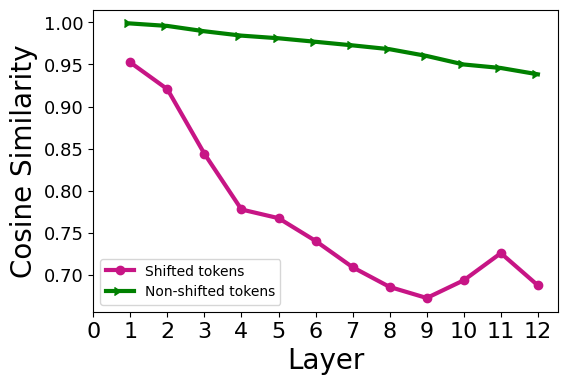

In [ ]:
plt.plot(range(1, 13), bi_distance, 'mediumvioletred', label="Shifted tokens", marker='o', linewidth=3)
plt.plot(range(1, 13), other_distance, 'green', label="Non-shifted tokens", marker=5, linewidth=3)
plt.legend(loc='best')
plt.xlabel("Layer", fontsize=20)
plt.ylabel("Cosine Similarity", fontsize=20)
plt.xticks(range(13), fontsize=16)
# plt.yticks(fontsize=16)
plt.rcParams['xtick.labelsize']=13
plt.rcParams['ytick.labelsize']=13
# plt.grid()
plt.show()

In [ ]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()

In [ ]:
performance = np.load("/home/username/NLP/Data/SentEval/data/probing/performance_scores.npy")

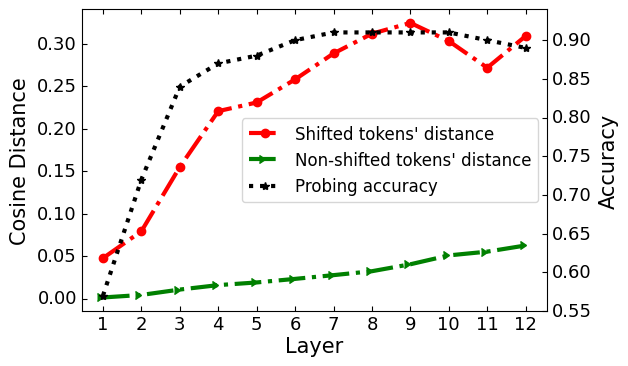

In [ ]:
#@title Sim_Performance
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
plt.rcParams['xtick.labelsize']=13
plt.rcParams['ytick.labelsize']=13
linewidth = 3

bi_dist = 1 - np.array(bi_distance)
other_dist = 1 - np.array(other_distance)

# plt.figure(dpi=100, figsize = (8,5))
plt.figure(dpi=100)
host = host_subplot(111, axes_class=AA.Axes) 
# plt.subplots_adjust(right=0.75)

par1 = host.twinx()

par1.axis["right"].toggle(all=True)

host.set_xlabel("Layer")

host.plot(range(1, 13), bi_dist, c='red', label="Shifted tokens' distance", marker='o', linestyle='dashdot', linewidth=linewidth)
host.plot(range(1, 13), other_dist, c='green', label="Non-shifted tokens' distance", marker=5, linestyle='dashdot', linewidth=linewidth)
host.set_ylabel("Cosine Distance")
host.set_xticks(range(13))
# host.set_ylim(0, 1.1)


par1.plot(range(1, 13), performance_score, c='black', label="Probing accuracy", linestyle='dotted', marker='*', linewidth=linewidth)
par1.set_xlabel("Layer")
par1.set_ylabel("Accuracy")
par1.set_ylim(0.55, 0.94)

host.axis["bottom"].label.set_fontsize(15)
host.axis["left"].label.set_fontsize(15)
par1.axis["right"].label.set_fontsize(15)


host.legend()
host.legend(loc="center right", prop={'size': 12}, frameon=True)
# plt.grid()

# plt.title("", fontsize=15)
# plt.title(r"""(a) "but" Coordinator""", fontsize=15)
# fig.tight_layout()
plt.draw()
plt.show()